# Import Packages

In [65]:
import pandas as pd
import numpy as np
import math
import collections
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
import ast
import random

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy

from wordcloud import WordCloud
from textwrap import wrap

from textblob import TextBlob

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm.auto import tqdm


# Data Preprocessing

## Reading Data

In [66]:
def load_data(filename : str, delimiter : str = ",") -> pd.DataFrame:
    df = pd.read_csv(filename, delimiter = delimiter, dtype={3: str})

    """
    TO BE REMOVED
    -> delete the preprocessing done by ckcherry directly in the csv file

    up to but not including the return statement
    """
    col_to_drop = ["Unnamed: 0",
                   "hashtag",
                   "tokens",
                   "upper_case",
                   "num_digits",
                   "num_hashtags",
                   "num_words",
                   "average_word_length",
                   "positive",
                   "neutral",
                   "negative",
                   "compound",
                   "label"]
    df.drop(col_to_drop, inplace = True, axis = 1)

    return df


In [67]:
df_train = load_data("full_train_preprocessed_subset.csv")
df_valid = load_data("full_val_preprocessed_subset.csv")
df_test = load_data("full_test_preprocessed_subset.csv")


In [68]:
# Data from Russell's repo
train = pd.read_csv("train.csv")
val = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [69]:
# Rename the 'tweets' column to 'text'
train.rename(columns={"tweets": "text"}, inplace=True)

# Combine train data
allowed_annotations = [1381, 1384, 1424, 1392, 1447, 186, 1389, 1420, 1620, 1403, 763, 1138, 1446]
allowed_set = set(allowed_annotations)


def process_annotation(ann_value):
    # If it's a single integer, convert it to a list
    if isinstance(ann_value, int):
        ann_value = [ann_value]

    # If it's a string representation of a list, parse it
    if isinstance(ann_value, str):
        try:
            ann_list = ast.literal_eval(ann_value)
        except Exception as e:
            print("Error parsing annotation:", ann_value, e)
            ann_list = []
    else:
        ann_list = ann_value

    # Filter out values that are not allowed
    filtered = [a for a in ann_list if a in allowed_set]

    if len(filtered) == 1:
        return filtered[0]
    elif len(filtered) > 1:
        return random.choice(filtered)
    else:
        return 0

# Apply the function to each row in 'train'
train['annotations'] = train['annotations'].apply(process_annotation)

# Drop the 'id' column
train.drop(columns=['id'], inplace=True)

# Concatenate row-wise with your existing df_train
df_train = pd.concat([df_train, train], axis=0, ignore_index=True)
df_train.drop_duplicates(inplace=True)

print(df_train.shape)

(189549, 2)


# Data Distribution


## Text Length Distribution

In [70]:
df_train['text_length'] = df_train['text'].apply(len)
train_stats = df_train.groupby('annotations')['text_length'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Train Statistics:\n", train_stats)

Train Statistics:
                   mean  median        std  min  max
annotations                                        
186          48.569155    37.0  35.796034    1  172
763          63.593621    56.0  34.077718    7  149
1138         66.488980    58.0  33.172891    6  148
1381         49.568002    42.0  33.133531    1  148
1384         49.848431    42.0  33.107284    1  150
1389         66.469986    58.0  35.829854    7  148
1392         40.144189    31.0  30.578340    1  509
1403         63.763679    53.0  35.097892    6  144
1420         57.587201    50.0  30.633113    7  151
1424         63.541509    57.0  31.467775    6  147
1446         61.382168    55.0  31.518749    6  152
1447         53.473951    42.0  44.541571    2  756
1620         62.321414    55.0  31.610170    6  148


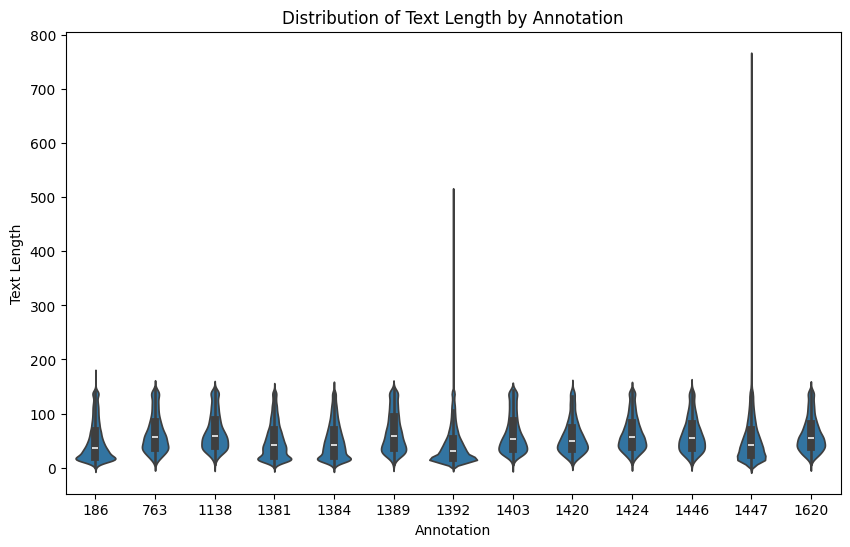

In [71]:
# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='annotations', y='text_length', data=df_train)
plt.title('Distribution of Text Length by Annotation')
plt.xlabel('Annotation')
plt.ylabel('Text Length')
plt.show()

## Repeated words

In [72]:
def count_repeated_words(text):
    words = text.lower().split()
    counts = collections.Counter(words)
    repeated_count = sum(count for count in counts.values() if count > 1)
    return repeated_count

df_train['repeated_words'] = df_train['text'].apply(count_repeated_words)

In [73]:
# Checking correctness
print(count_repeated_words("hello world hello world hello world")) # the result should be 6
print(count_repeated_words("good morning good evening good afternoon beautiful evening hello afternoon")) # the result should be 7
print(count_repeated_words("hello")) # the result should be 0

6
7
0


In [74]:
repeated_stats = df_train.groupby('annotations')['repeated_words'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Repeated Words Statistics:\n", repeated_stats)

Repeated Words Statistics:
                  mean  median       std  min  max
annotations                                      
186          0.568034     0.0  1.510033    0   27
763          0.853086     0.0  1.904334    0   19
1138         1.129351     0.0  2.180124    0   21
1381         0.539541     0.0  1.399583    0   20
1384         0.589930     0.0  1.452287    0   19
1389         0.738607     0.0  1.734927    0   29
1392         0.312309     0.0  1.079192    0   28
1403         0.647135     0.0  1.548053    0   17
1420         0.796361     0.0  1.734598    0   17
1424         0.820625     0.0  1.746783    0   19
1446         0.950760     0.0  1.877859    0   35
1447         0.735358     0.0  1.934249    0   28
1620         0.826114     0.0  1.745686    0   22


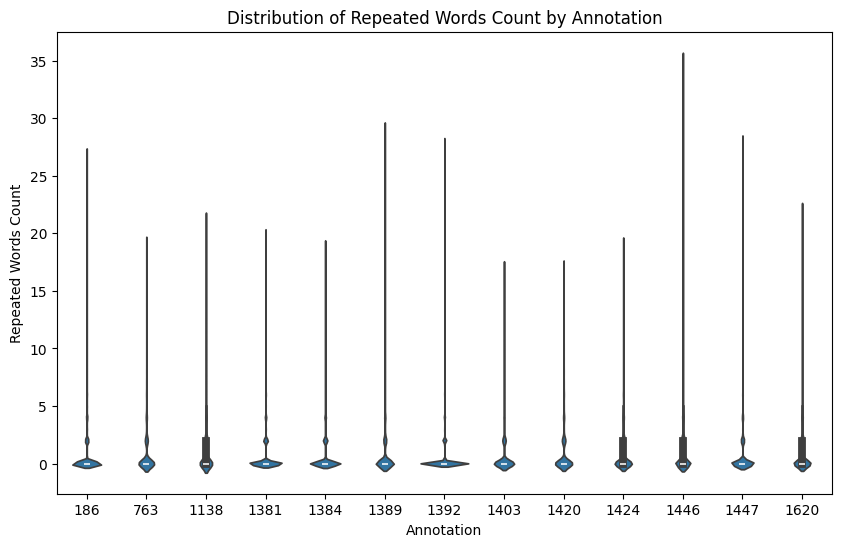

In [75]:
# Create the violin plot for the repeated words distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='annotations', y='repeated_words', data=df_train)
plt.title('Distribution of Repeated Words Count by Annotation')
plt.xlabel('Annotation')
plt.ylabel('Repeated Words Count')
plt.show()

## Words count

In [76]:
# Count words in each text entry
df_train['word_count'] = df_train['text'].apply(lambda x: len(x.split()))

# Calculate descriptive statistics for word counts grouped by annotations
word_stats = df_train.groupby('annotations')['word_count'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Word Count Statistics:\n", word_stats)

Word Count Statistics:
                   mean  median       std  min  max
annotations                                       
186           8.061541     6.0  6.477783    1   40
763          11.190123    10.0  6.413615    2   37
1138         12.105252    11.0  6.503196    2   36
1381          8.586418     7.0  6.236937    1   50
1384          8.724891     7.0  6.284765    1   32
1389         11.362176    10.0  6.530291    2   36
1392          6.574052     5.0  5.327745    1   44
1403         10.522835     9.0  6.402402    2   37
1420         11.059293     9.0  6.084759    2   36
1424         11.468047    10.0  6.299075    2   37
1446         11.877001    11.0  6.283215    2   37
1447          9.374886     7.0  7.785876    1   76
1620         11.531058    10.0  6.032218    2   32


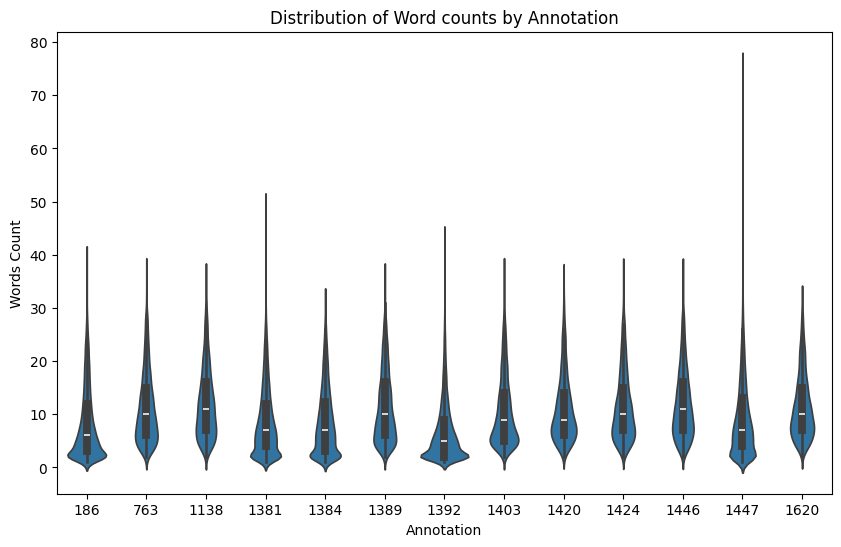

In [77]:
# Create the violin plot for the words count distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='annotations', y='word_count', data=df_train)
plt.title('Distribution of Word counts by Annotation')
plt.xlabel('Annotation')
plt.ylabel('Words Count')
plt.show()

## Average Word Length

In [78]:
# Compute the average word length for each row
df_train['avg_word_length'] = df_train['text'].apply(
    lambda x: np.mean([len(word) for word in x.split()]) if x.strip() else 0
)

# Calculate descriptive statistics for average word length grouped by annotations
avg_length_stats = df_train.groupby('annotations')['avg_word_length'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Average Word Length Statistics:\n", avg_length_stats)

Average Word Length Statistics:
                  mean    median       std       min        max
annotations                                                   
186          5.647813  5.222222  1.845587  1.000000  36.250000
763          5.117009  4.640000  1.806230  1.111111  18.000000
1138         4.937434  4.400000  1.780219  1.666667  17.000000
1381         5.286011  4.894737  1.702200  1.000000  28.000000
1384         5.229736  4.833333  1.633879  1.000000  27.000000
1389         5.221590  4.900000  1.593803  1.666667  17.333333
1392         5.651628  5.200000  1.962430  1.000000  27.750000
1403         5.512000  5.200000  1.632909  1.081081  19.000000
1420         4.544143  4.111111  1.632421  1.750000  19.000000
1424         5.018232  4.500000  1.820443  1.400000  19.500000
1446         4.462702  4.100000  1.432833  1.000000  16.500000
1447         5.173492  4.782609  1.642467  1.000000  18.000000
1620         4.699398  4.363636  1.440656  1.000000  14.500000


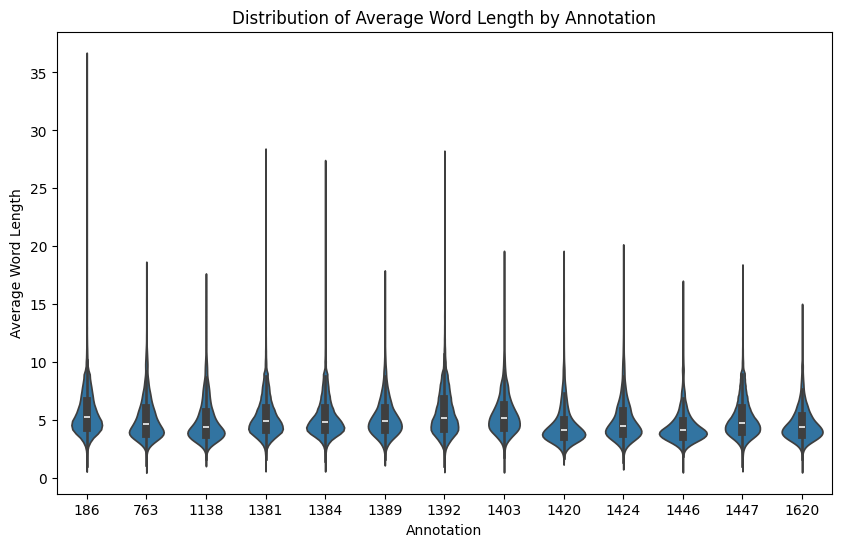

In [79]:
# Create the violin plot for the average word length distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='annotations', y='avg_word_length', data=df_train)
plt.title('Distribution of Average Word Length by Annotation')
plt.xlabel('Annotation')
plt.ylabel('Average Word Length')
plt.show()

## Stop Words Frequency

In [80]:
# Initialize the set of stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Compute the stop word frequency for each row:
df_train['stopword_count'] = df_train['text'].apply(
    lambda x: sum(1 for word in x.split() if word.lower() in stop_words)
)

# Calculate descriptive statistics for stop word frequency grouped by annotations
stopword_stats = df_train.groupby('annotations')['stopword_count'].agg(['mean', 'median', 'std', 'min', 'max'])
print("Stop Word Frequency Statistics:\n", stopword_stats)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Stop Word Frequency Statistics:
                  mean  median       std  min  max
annotations                                      
186          2.782595     2.0  3.201341    0   19
763          3.644856     3.0  3.355859    0   20
1138         4.021215     3.0  3.420075    0   24
1381         3.224248     2.0  3.176631    0   20
1384         3.492241     3.0  3.369519    0   21
1389         3.627585     3.0  3.348265    0   20
1392         2.120895     1.0  2.549648    0   19
1403         2.869237     2.0  3.010347    0   18
1420         4.131262     3.0  3.223055    0   20
1424         4.091778     3.0  3.290425    0   18
1446         4.664640     4.0  3.488413    0   19
1447         3.656648     3.0  3.841450    0   33
1620         4.275439     4.0  3.206010    0   21


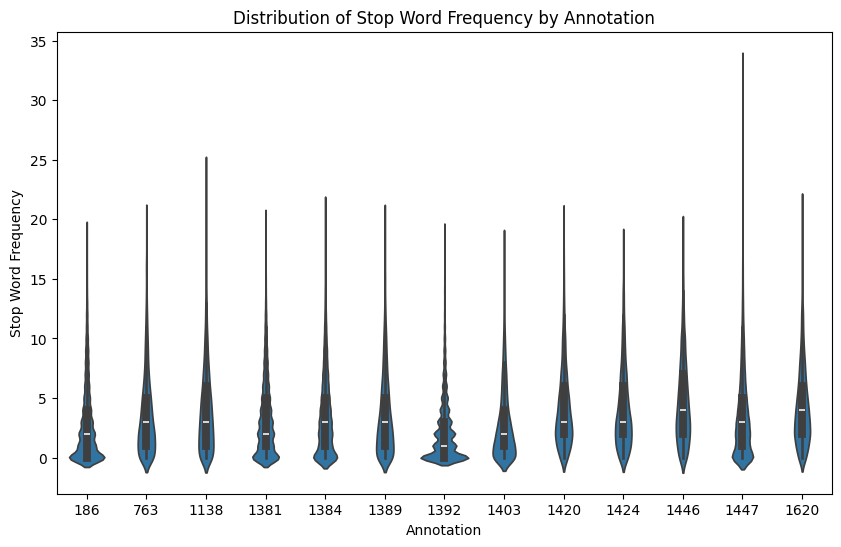

In [81]:
# Create the violin plot for the stop word frequency distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='annotations', y='stopword_count', data=df_train)
plt.title('Distribution of Stop Word Frequency by Annotation')
plt.xlabel('Annotation')
plt.ylabel('Stop Word Frequency')
plt.show()

# Data Preparation

## Re-Tweet Encoding

In [82]:
# Encode RT / Re-Tweet [encoding_RT]
def encoding_RT(df: pd.DataFrame):
    df["text"] = df["text"].str.replace("^RT\\s+", "", regex=True)
    df["text"] = df["text"].str.replace("^RT$", "", regex = True)
    return df

encoding_RT(df_train)

,annotations,text,text_length,repeated_words,word_count,avg_word_length,stopword_count
0,1384,Nobody go to Walmart in sulphur,31,0,6,4.333333,2
1,1384,@emberlhamon @MLidak welcome to the ugly club!!,48,0,7,5.857143,2
2,1384,getting to help coach jr high,29,0,6,4.000000,1
3,1384,Yo Gotti and Black Youngsta on stage we all th...,60,2,12,4.000000,6
4,1384,@spenceribarra just making sure I haven't been...,56,0,8,6.000000,4
...,...,...,...,...,...,...,...
193994,1403,thanks baby daddy lmao 😘I'll miss you too! htt...,66,0,9,6.444444,1
193995,1403,@darciee5sos it's been a while lad I miss u 😘,45,0,10,3.600000,5
193996,1403,Had a quick visit to my bff @giannecarongoy 😘\...,117,2,19,5.210526,4
193997,1403,@laylalee68: GN 😘 Off to watch my football tea...,140,0,20,6.050000,3


In [83]:
# Checking correctness
print(encoding_RT(pd.DataFrame({'text': ['RT cs3244 machine learning']}))) # should return cs3244 machine learning

                      text
0  cs3244 machine learning


## Tag Removal


In [84]:
def extract_tags_and_text(tweet):
    tags = re.findall(r"@\w+", tweet)
    text = re.sub(r"@\w+", "", tweet)
    text = text.strip()
    return pd.Series([text, tags], index=["text", "tags"])

def tag_removal(df: pd.DataFrame) -> pd.DataFrame:
    df[["text", "tags"]] = df["text"].apply(extract_tags_and_text)
    return df

tag_removal(df_train)

,annotations,text,text_length,repeated_words,word_count,avg_word_length,stopword_count,tags
0,1384,Nobody go to Walmart in sulphur,31,0,6,4.333333,2,[]
1,1384,welcome to the ugly club!!,48,0,7,5.857143,2,"[@emberlhamon, @MLidak]"
2,1384,getting to help coach jr high,29,0,6,4.000000,1,[]
3,1384,Yo Gotti and Black Youngsta on stage we all th...,60,2,12,4.000000,6,[]
4,1384,just making sure I haven't been replaced,56,0,8,6.000000,4,[@spenceribarra]
...,...,...,...,...,...,...,...,...
193994,1403,thanks baby daddy lmao 😘I'll miss you too! htt...,66,0,9,6.444444,1,[]
193995,1403,it's been a while lad I miss u 😘,45,0,10,3.600000,5,[@darciee5sos]
193996,1403,Had a quick visit to my bff 😘\nVisit Hungry h...,117,2,19,5.210526,4,[@giannecarongoy]
193997,1403,: GN 😘 Off to watch my football team - Austral...,140,0,20,6.050000,3,"[@laylalee68, @FfdpGitte, @FanGirl1168, @Bklin..."


In [85]:
# Checking correctness
print(tag_removal(pd.DataFrame({'text': ['@cs3244 machine learning']}))) # this should return machine learning

               text       tags
0  machine learning  [@cs3244]


## Lower Case Text

In [86]:
df_train["text"] = df_train["text"].str.lower()

## Tokenize, Stop Words Removal and Lemmatize

In [87]:
# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

def spacy_tokenize_and_lemmatize(text):
    """
    Use spaCy to tokenize, remove stopwords, and lemmatize in one pass.
    Returns a list of lemmas.
    """
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return tokens

# Apply the function to DataFrame
df_train['tokens'] = df_train['text'].apply(spacy_tokenize_and_lemmatize)

In [88]:
# Checking correctness
test_df = pd.DataFrame({
    'text': [
        "The cats are running in the fields!",       # Expect tokens like ['cat', 'run', 'field']
        "Machine learning is amazing, isn't it?"     # Expect tokens like ['machine', 'learning', 'amazing']
    ]
})

test_df['tokens'] = test_df['text'].apply(spacy_tokenize_and_lemmatize)

# Print the DataFrame to inspect the output
print(test_df)

                                     text                        tokens
0     The cats are running in the fields!             [cat, run, field]
1  Machine learning is amazing, isn't it?  [machine, learning, amazing]


# EDA

## Frequent Words

<ipython-input-89-4b4c6a9da2e0>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45, ha="right")
<ipython-input-89-4b4c6a9da2e0>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45, ha="right")
<ipython-input-89-4b4c6a9da2e0>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45, ha="right")
<ipython-input-89-4b4c6a9da2e0>:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(words, rotation=45, ha="right")
<ipython-input-89-4b4c6a9da2e0>:25: UserWarning: set_ticklabels() should only be used with a fixed number of tic

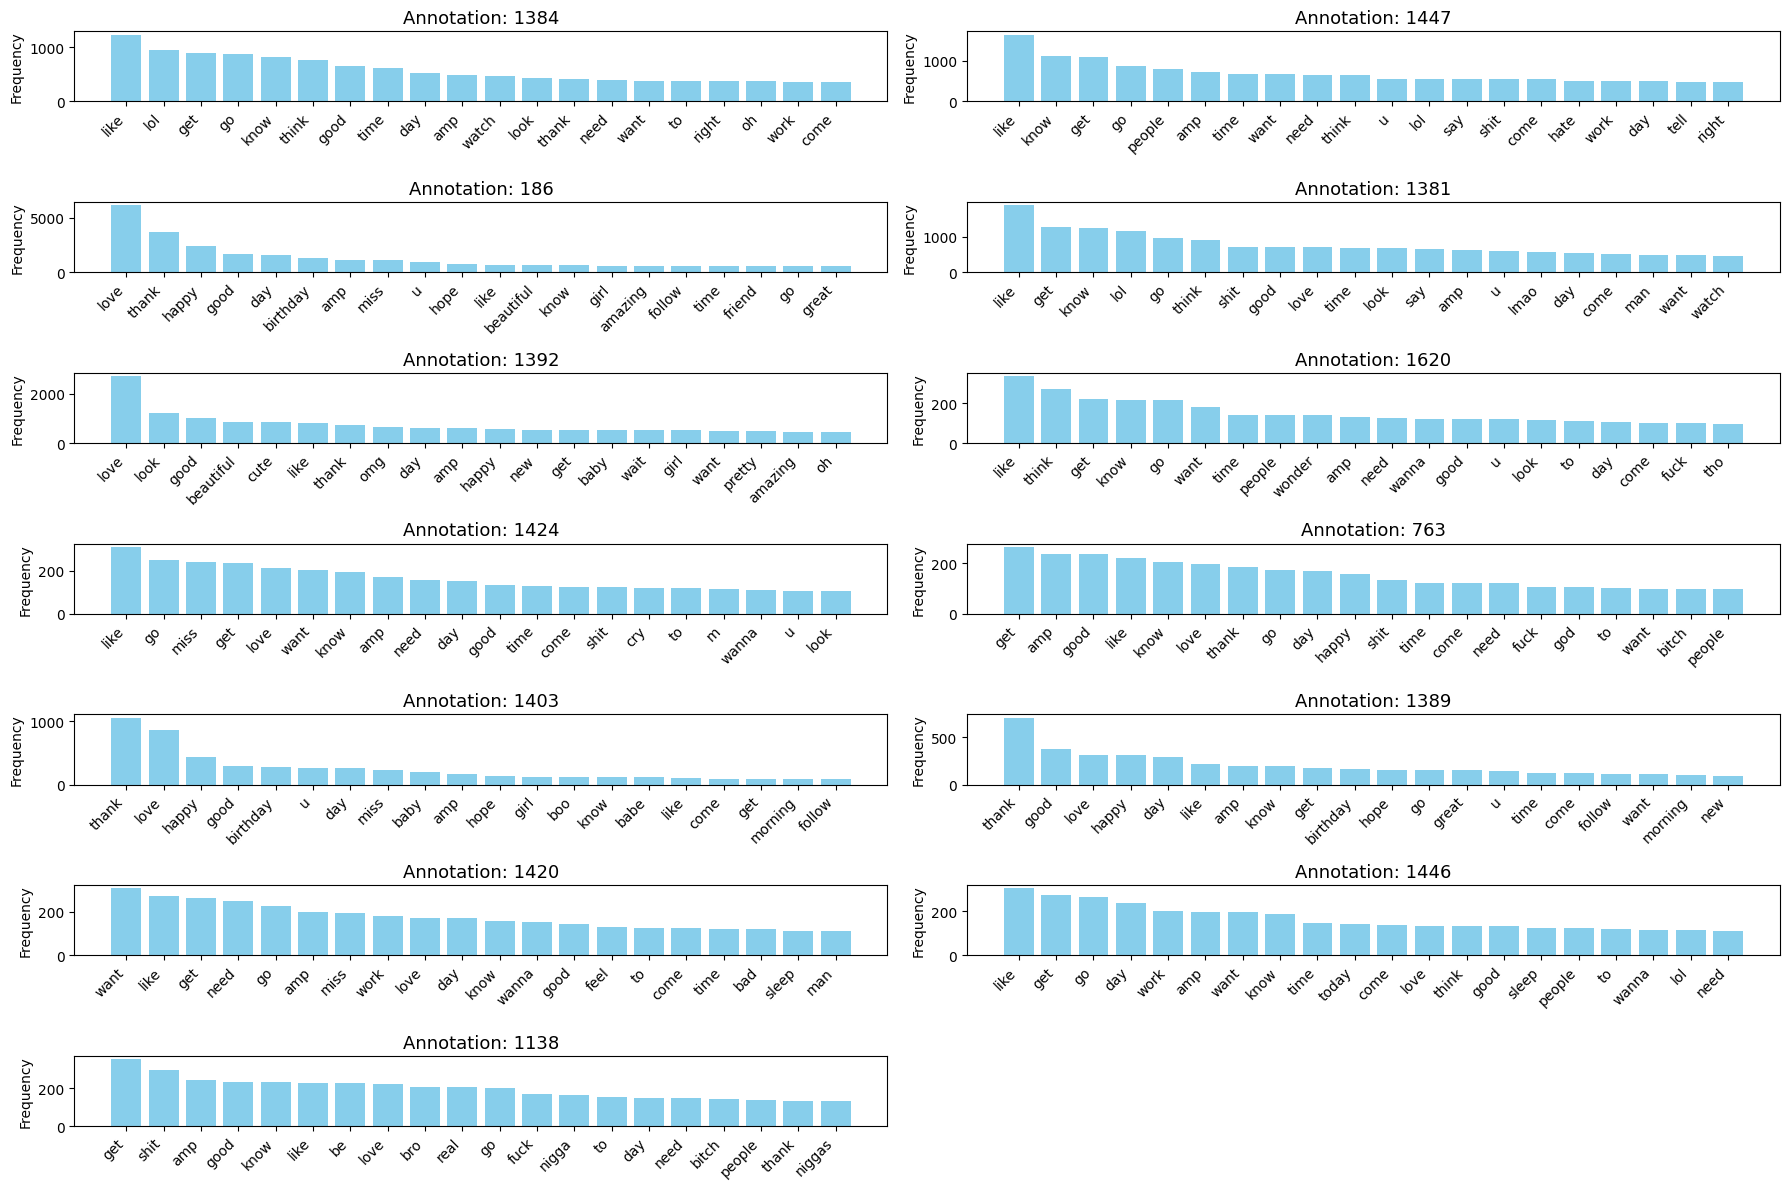

In [89]:
unique_annotations = df_train['annotations'].unique()
num_annotations = len(unique_annotations)
ncols = 2
nrows = math.ceil(num_annotations / ncols)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 12))
axes = axes.flatten()

for i, annotation in enumerate(unique_annotations):
    # Filter rows for this annotation and flatten tokens into one list
    subset = df_train[df_train['annotations'] == annotation]
    all_tokens = [token for tokens_list in subset['tokens'] for token in tokens_list]

    # Count frequencies and get the top 20 words
    freq_dict = Counter(all_tokens)
    top_20 = freq_dict.most_common(20)
    words = [word for word, freq in top_20]
    freqs = [freq for word, freq in top_20]

    # Plot the bar chart in the corresponding subplot
    axes[i].bar(words, freqs, color="skyblue")
    axes[i].set_title(f"Annotation: {annotation}", fontsize=13)
    axes[i].set_ylabel("Frequency")
    axes[i].set_xticklabels(words, rotation=45, ha="right")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

## Word Clouds

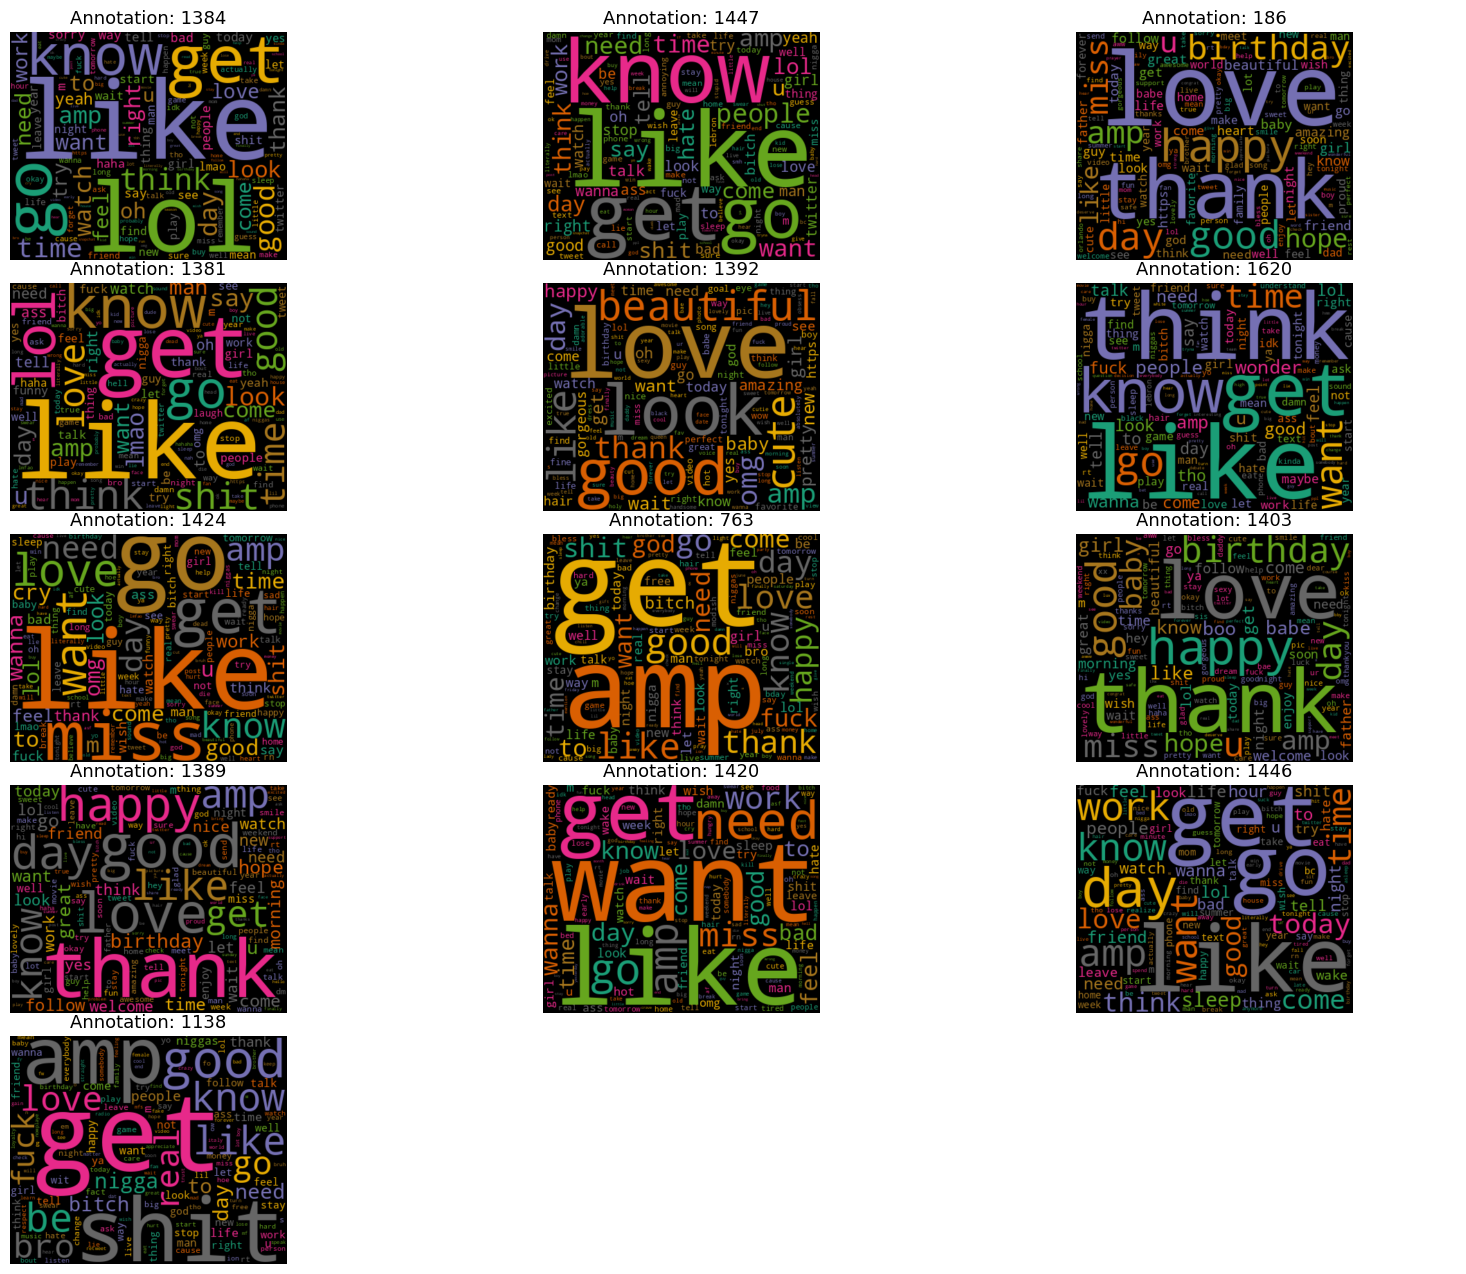

In [105]:
def generate_wordcloud(freq_dict):
    wc = WordCloud(width=400, height=330, max_words=150, colormap="Dark2")
    wc.generate_from_frequencies(freq_dict)
    return wc

num_annotations = len(unique_annotations)
ncols = 3
nrows = math.ceil(num_annotations / ncols)

# Create a figure with subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,16))
axes = axes.flatten()

for i, annotation in enumerate(unique_annotations):
    subset = df_train[df_train['annotations'] == annotation]
    all_tokens = [token for tokens_list in subset['tokens'] for token in tokens_list]

    freq_dict = Counter(all_tokens)
    wc = generate_wordcloud(freq_dict)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis("off")
    axes[i].set_title(f"Annotation: {annotation}", fontsize=13)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


## Polarity & Subjectivity Checking


In [91]:
# Compute polarity and subjectivity for each tweet
df_train['polarity'] = df_train['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_train['subjectivity'] = df_train['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Print sample rows to check results
print(df_train[['text', 'polarity', 'subjectivity']].sample(5))


                                       text  polarity  subjectivity
42138                   i got the same snap      0.00      0.125000
6948                                   damn      0.00      0.000000
118436                            dem locks      0.00      0.000000
99448              first thing i thought of      0.25      0.333333
22420   then curtis can be with his cupcake      0.00      0.000000


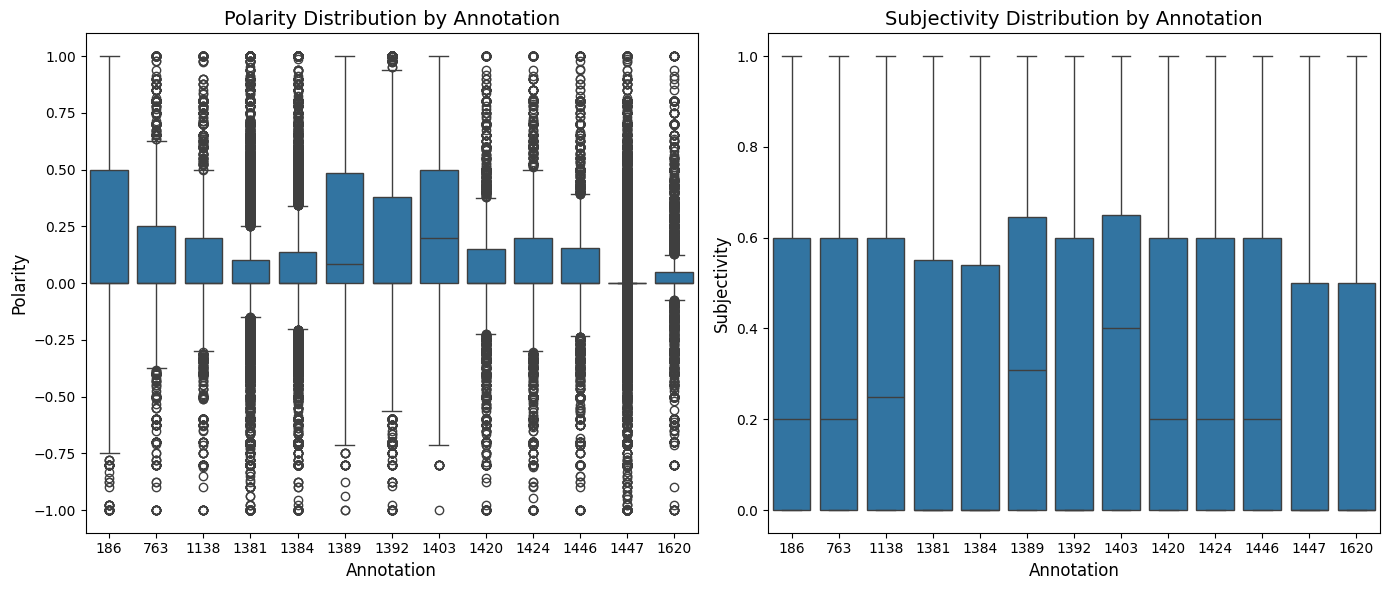

In [92]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(ncols=2, figsize=(14, 6))

# Boxplot for polarity distribution by annotation
sns.boxplot(x='annotations', y='polarity', data=df_train, ax=axes[0])
axes[0].set_title('Polarity Distribution by Annotation', fontsize=14)
axes[0].set_xlabel('Annotation', fontsize=12)
axes[0].set_ylabel('Polarity', fontsize=12)

# Boxplot for subjectivity distribution by annotation
sns.boxplot(x='annotations', y='subjectivity', data=df_train, ax=axes[1])
axes[1].set_title('Subjectivity Distribution by Annotation', fontsize=14)
axes[1].set_xlabel('Annotation', fontsize=12)
axes[1].set_ylabel('Subjectivity', fontsize=12)

plt.tight_layout()
plt.show()

In [93]:
# Polarity stats accross annotation
polarity_stats = df_train.groupby('annotations')['polarity'].agg(['mean', 'median', 'std', 'min', 'max'])
print(polarity_stats)

                 mean    median       std  min  max
annotations                                        
186          0.222724  0.000000  0.316681 -1.0  1.0
763          0.115772  0.000000  0.306724 -1.0  1.0
1138         0.080096  0.000000  0.298601 -1.0  1.0
1381         0.061096  0.000000  0.282554 -1.0  1.0
1384         0.065968  0.000000  0.276636 -1.0  1.0
1389         0.221507  0.083333  0.332522 -1.0  1.0
1392         0.174067  0.000000  0.303671 -1.0  1.0
1403         0.274130  0.200000  0.326491 -1.0  1.0
1420         0.034847  0.000000  0.301193 -1.0  1.0
1424         0.050987  0.000000  0.312536 -1.0  1.0
1446         0.045751  0.000000  0.298794 -1.0  1.0
1447         0.010680  0.000000  0.266929 -1.0  1.0
1620         0.039293  0.000000  0.252394 -1.0  1.0


In [94]:
# Subjectivity stats accross annotation
subjectivity_stats = df_train.groupby('annotations')['subjectivity'].agg(['mean', 'median', 'std', 'min', 'max'])
print(subjectivity_stats)

                 mean    median       std  min  max
annotations                                        
186          0.327935  0.200000  0.356494  0.0  1.0
763          0.319031  0.200000  0.344918  0.0  1.0
1138         0.317786  0.250000  0.333737  0.0  1.0
1381         0.274301  0.000000  0.345123  0.0  1.0
1384         0.274113  0.000000  0.335543  0.0  1.0
1389         0.364281  0.308333  0.352634  0.0  1.0
1392         0.303433  0.000000  0.374582  0.0  1.0
1403         0.396918  0.400000  0.353634  0.0  1.0
1420         0.316330  0.200000  0.347194  0.0  1.0
1424         0.334559  0.200000  0.355389  0.0  1.0
1446         0.316738  0.200000  0.342057  0.0  1.0
1447         0.259747  0.000000  0.333822  0.0  1.0
1620         0.259767  0.000000  0.321259  0.0  1.0


## Sentiment Analysis

In [95]:
# Check GPU Availability (Colab)
device = 0 if torch.cuda.is_available() else -1
print("Using device:", "GPU" if device == 0 else "CPU")

# Choose a Pretrained Sentiment Model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create a pipeline for sentiment analysis, specifying the device for GPU
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    device=device
)

batch_size = 32
all_results = []

# Convert the 'text' column to a list for convenience
texts = df_train['text'].tolist()

# Use tqdm for a progress bar
for i in tqdm(range(0, len(texts), batch_size), desc="Processing Batches"):
    batch_texts = texts[i:i+batch_size]
    # Pass the batch to the pipeline
    batch_results = sentiment_pipeline(batch_texts, truncation=True, padding=True)
    all_results.extend(batch_results)

labels = [res['label'] for res in all_results]
scores = [res['score'] for res in all_results]

# Add them to your DataFrame
df_train['bert_sentiment_label'] = labels
df_train['bert_sentiment_score'] = scores

Using device: GPU


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Device set to use cuda:0


Processing Batches:   0%|          | 0/5924 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [96]:
# Example: top 3 positive, top 3 negative
top_positive = df_train.nlargest(3, 'bert_sentiment_score')[['text','bert_sentiment_label','bert_sentiment_score']]
top_negative = df_train.nsmallest(3, 'bert_sentiment_score')[['text','bert_sentiment_label','bert_sentiment_score']]

print("\nTop 3 Most Positive Samples:")
print(top_positive)

print("\nTop 3 Most Negative Samples:")
print(top_negative)


Top 3 Most Positive Samples:
                                                     text  \
121411  there's so much beauty and awesomeness in one ...   
41880   : what a beautiful girl! she's so talented, hu...   
52844   seeing people appreciate charmed makes my hear...   

       bert_sentiment_label  bert_sentiment_score  
121411             POSITIVE              0.999895  
41880              POSITIVE              0.999893  
52844              POSITIVE              0.999892  

Top 3 Most Negative Samples:
                                                     text  \
156452                                 can it be friday 😭   
181799  you really need to stop, i'm so jealous of you...   
31685   nope . ibadah is the best but sometimes entert...   

       bert_sentiment_label  bert_sentiment_score  
156452             POSITIVE              0.500003  
181799             POSITIVE              0.500023  
31685              NEGATIVE              0.500100  


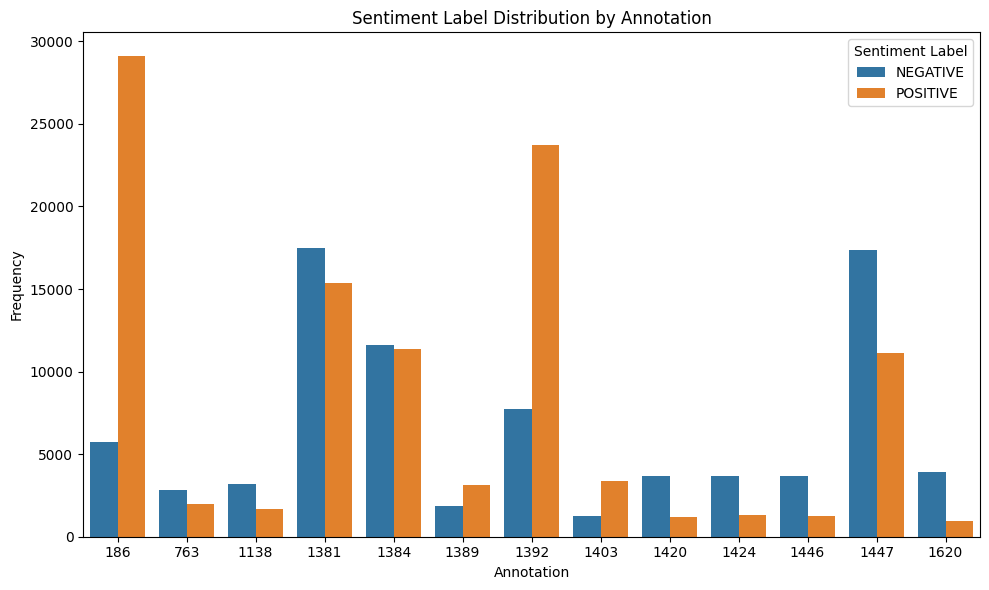

In [97]:
# Group by (annotation, sentiment_label) and count the occurrences
label_counts = df_train.groupby(['annotations', 'bert_sentiment_label']).size().reset_index(name='count')

# Create a grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='annotations', y='count', hue='bert_sentiment_label', data=label_counts)
plt.title('Sentiment Label Distribution by Annotation')
plt.xlabel('Annotation')
plt.ylabel('Frequency')
plt.legend(title='Sentiment Label')
plt.tight_layout()
plt.show()

BERT Sentiment Score Statistics:
                  mean    median       std       min       max
annotations                                                  
186          0.940691  0.998252  0.106067  0.500844  0.999893
763          0.954747  0.992068  0.094341  0.500740  0.999886
1138         0.957596  0.992210  0.089522  0.501467  0.999887
1381         0.935322  0.991891  0.107536  0.500362  0.999890
1384         0.932475  0.991661  0.109686  0.500100  0.999887
1389         0.964175  0.996161  0.083990  0.500977  0.999888
1392         0.931931  0.994308  0.111070  0.500143  0.999895
1403         0.965727  0.997281  0.085986  0.502676  0.999887
1420         0.959866  0.993438  0.088224  0.500023  0.999880
1424         0.963338  0.994116  0.086048  0.500003  0.999880
1446         0.960461  0.994138  0.088961  0.505374  0.999883
1447         0.935969  0.992518  0.106904  0.500299  0.999890
1620         0.958003  0.992909  0.089574  0.501001  0.999870


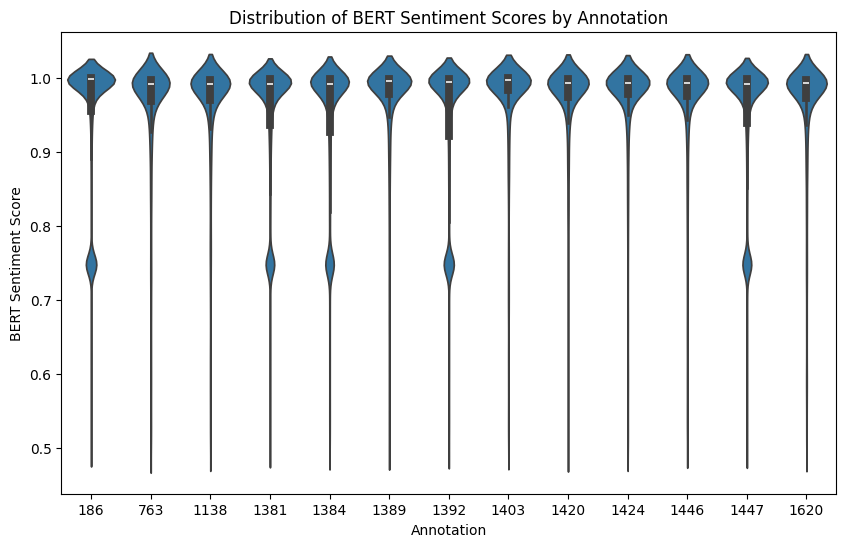

In [98]:
# Calculate descriptive statistics for BERT sentiment scores grouped by annotations
sentiment_stats = df_train.groupby('annotations')['bert_sentiment_score'].agg(['mean', 'median', 'std', 'min', 'max'])
print("BERT Sentiment Score Statistics:\n", sentiment_stats)

# Create the violin plot for the BERT sentiment score distribution
plt.figure(figsize=(10, 6))
sns.violinplot(x='annotations', y='bert_sentiment_score', data=df_train)
plt.title('Distribution of BERT Sentiment Scores by Annotation')
plt.xlabel('Annotation')
plt.ylabel('BERT Sentiment Score')
plt.show()
